In [8]:

import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
import tensorflow as tf
from tensorflow.keras.models import load_model

In [9]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

#Define a function to plot the loss per epoch 
def plot_loss(history):
    plt.figure()
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)
    plt.figure()
    plt.plot(history.history['accuracy'], label="acc")
    plt.plot(history.history['val_accuracy'], label="val.acc")
    plt.xlabel('Epoch')
    plt.ylabel('Acc.')
    
    #Define the model again with the optimal params.

In [10]:
#Load colorplot datasets. 
X = np.load('data.npz')['a'].reshape(5179, 200, 100, 1)

#Creating the labels. 
y = pd.read_excel('Labels_v1.xlsx', header = None).values

#Shuffling the dataset.
shuffler = np.random.permutation(len(y))
X = X[shuffler]
y = y[shuffler]
class_weights = generate_class_weights(y[:,0])
print(class_weights)
print(np.unique(y[:,0]))

{0: 0.5977608494921515, 1: 3.0572609208972845}
[0 1]


In [11]:
def train():
    # Define the K-fold Cross Validator
    num_folds = 5
    kfold = KFold(n_splits=num_folds, shuffle=True)
    
    opt = tf.keras.optimizers.Adam(
    learning_rate=1e-06,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",    
    )
    
    

    inputs = X
    targets = np.asarray(y).astype('float32').reshape((-1,1))
    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        #Train the model
        filepath = "BestModel_Fold-" + str(fold_no) + ".h5"
        es = [EarlyStopping(monitor='val_loss', mode='min', patience=20, min_delta=0.01), tf.keras.callbacks.ModelCheckpoint(
        filepath,
        monitor="val_loss",
        verbose=1,
        save_best_only=True
        )]
        
        net = build_cnn()
        net.compile(loss='binary_crossentropy',
                optimizer=opt, metrics="accuracy")
        
        history = net.fit(
        inputs[train], targets[train],                         # changed expression for test features and labels
        validation_split=0.25,                                 # I removed validation for k-fold cross validation
        verbose=1, epochs=10000, 
        class_weight = class_weights, callbacks=es)
        
        newfig = plt.figure()
        plot_loss(history)

        plt.show()
        #Prediction of the validation dataset 
        test_predictions = net.predict(inputs[test]).flatten()
        fold_no = fold_no + 1

In [12]:

def build_cnn():
    net = Sequential()
    net.add(Conv2D(activation='relu',filters=32, kernel_size=(5, 5), input_shape=(200, 100, 1)))
    net.add(BatchNormalization())
    net.add(Conv2D(64, (3, 3), activation='relu'))
    net.add(MaxPool2D(pool_size=(2, 2)))
    net.add(BatchNormalization())
    net.add(Dropout(0.4))
    net.add(Conv2D(128, (3,3), strides=2, activation='relu'))
    net.add(BatchNormalization())
    net.add(Dropout(0.4))
    net.add(Flatten())
    net.add(Dense(256, activation='relu'))
    net.add(Dropout(rate=0.5))
    net.add(Dense(1, activation='sigmoid'))

    # net.build(input_shape=(200, 100, 1))
    summary = net.summary()

    plot_model(net, to_file='network_structure.png', show_shapes=True)

    print(summary)

    return net

In [13]:
def test(filename):
    net = load_model(filename)
    labels_train = y
    
    outputs = net.predict(X)
    labels_predicted = np.argmax(outputs, axis=1)
    misclassified = sum(labels_predicted != labels_train)
    print('Percentage misclassified = ',
          100*misclassified/labels_train.size)
    print('Percentage misclassified = ',
          sum(100*misclassified/labels_train.size)/labels_train.size)

    plt.figure(figsize=(8, 2))
    for i in range(0, 8):
        ax = plt.subplot(2, 8, i+1)
        plt.imshow(X[i, :].reshape(200, 100), cmap=plt.get_cmap('gray_r'))
        plt.title(labels_train[i])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    for i in range(0, 8):
        output = net.predict(X[i, :].reshape(1, 200, 100, 1))
        output = output[0, 0:]
        plt.subplot(2, 8, 8+i+1)
        plt.bar(np.arange(10.), output)
        plt.title(np.argmax(output))

    net.summary()

    plot_model(net, to_file='network_structure.png', show_shapes=True)
    plt.show()


# earlystoping
# model checkpoint

Metal device set to: Apple M1 Max


2022-03-20 16:56:30.576841: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-20 16:56:30.576968: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 196, 96, 32)       832       
                                                                 
 batch_normalization (BatchN  (None, 196, 96, 32)      128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 97, 47, 64)       0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 97, 47, 64)       256       
 hNormalization)                                                 
                                                        

2022-03-20 16:56:31.116897: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-20 16:56:31.337589: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.8592 - accuracy: 0.6382

2022-03-20 16:56:41.465602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 1.36318, saving model to BestModel_Fold-1.h5
98/98 [==============================] - 13s 124ms/step - loss: 0.8592 - accuracy: 0.6382 - val_loss: 1.3632 - val_accuracy: 0.1660
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.6488 - accuracy: 0.7094
Epoch 00002: val_loss did not improve from 1.36318
98/98 [==============================] - 12s 123ms/step - loss: 0.6488 - accuracy: 0.7090 - val_loss: 1.9472 - val_accuracy: 0.1660
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.5368 - accuracy: 0.7603
Epoch 00003: val_loss did not improve from 1.36318
98/98 [==============================] - 12s 122ms/step - loss: 0.5363 - accuracy: 0.7605 - val_loss: 1.8744 - val_accuracy: 0.1670
Epoch 4/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4481 - accuracy: 0.7813
Epoch 00004: val_loss did not improve from 1.36318
98/98 [==============================] - 12s 121ms/step - loss: 0.4489 

Epoch 28/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1985 - accuracy: 0.9153
Epoch 00028: val_loss did not improve from 0.41667
98/98 [==============================] - 12s 120ms/step - loss: 0.1984 - accuracy: 0.9154 - val_loss: 0.4510 - val_accuracy: 0.7867
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1960 - accuracy: 0.9191
Epoch 00029: val_loss did not improve from 0.41667
98/98 [==============================] - 12s 124ms/step - loss: 0.1958 - accuracy: 0.9192 - val_loss: 0.4320 - val_accuracy: 0.8002
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9204
Epoch 00030: val_loss improved from 0.41667 to 0.39443, saving model to BestModel_Fold-1.h5
98/98 [==============================] - 12s 125ms/step - loss: 0.1880 - accuracy: 0.9205 - val_loss: 0.3944 - val_accuracy: 0.8205
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1663 - accuracy: 0.9298
Epoch 00031: val_l

Epoch 57/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0909 - accuracy: 0.9655
Epoch 00057: val_loss did not improve from 0.34480
98/98 [==============================] - 12s 122ms/step - loss: 0.0912 - accuracy: 0.9652 - val_loss: 0.3636 - val_accuracy: 0.8456
Epoch 58/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0931 - accuracy: 0.9684
Epoch 00058: val_loss did not improve from 0.34480
98/98 [==============================] - 12s 121ms/step - loss: 0.0930 - accuracy: 0.9685 - val_loss: 0.3662 - val_accuracy: 0.8427
Epoch 59/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0985 - accuracy: 0.9649
Epoch 00059: val_loss did not improve from 0.34480
98/98 [==============================] - 12s 120ms/step - loss: 0.0985 - accuracy: 0.9649 - val_loss: 0.3783 - val_accuracy: 0.8369
Epoch 60/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0983 - accuracy: 0.9584
Epoch 00060: val_loss did not improve from 0.34480
98/98 [=

<Figure size 432x288 with 0 Axes>

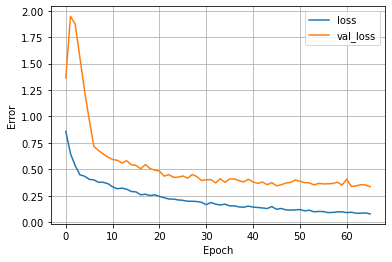

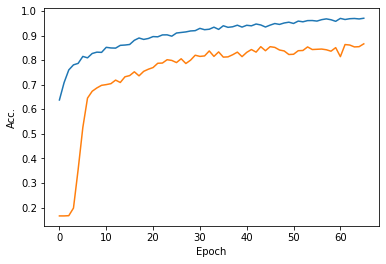

2022-03-20 17:09:46.690732: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_3 (Batc  (None, 196, 96, 32)      128       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 97, 47, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 97, 47, 64)       256       
 hNormalization)                                                 
                                                      

2022-03-20 17:09:49.344774: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.6665 - accuracy: 0.7358

2022-03-20 17:09:59.351029: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 2.26277, saving model to BestModel_Fold-2.h5
98/98 [==============================] - 13s 126ms/step - loss: 0.6665 - accuracy: 0.7358 - val_loss: 2.2628 - val_accuracy: 0.1535
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4864 - accuracy: 0.7880
Epoch 00002: val_loss did not improve from 2.26277
98/98 [==============================] - 12s 123ms/step - loss: 0.4860 - accuracy: 0.7882 - val_loss: 2.3626 - val_accuracy: 0.1535
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4094 - accuracy: 0.8189
Epoch 00003: val_loss improved from 2.26277 to 2.01281, saving model to BestModel_Fold-2.h5
98/98 [==============================] - 12s 124ms/step - loss: 0.4091 - accuracy: 0.8191 - val_loss: 2.0128 - val_accuracy: 0.1544
Epoch 4/10000
97/98 [============================>.] - ETA: 0s - loss: 0.3792 - accuracy: 0.8302
Epoch 00004: val_loss improved from 2.01281 to 1.80491, saving model to BestModel

97/98 [============================>.] - ETA: 0s - loss: 0.1735 - accuracy: 0.9272
Epoch 00028: val_loss did not improve from 0.58321
98/98 [==============================] - 12s 121ms/step - loss: 0.1733 - accuracy: 0.9273 - val_loss: 0.6566 - val_accuracy: 0.6950
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1509 - accuracy: 0.9333
Epoch 00029: val_loss did not improve from 0.58321
98/98 [==============================] - 12s 120ms/step - loss: 0.1509 - accuracy: 0.9331 - val_loss: 0.5928 - val_accuracy: 0.7104
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1522 - accuracy: 0.9349
Epoch 00030: val_loss improved from 0.58321 to 0.54205, saving model to BestModel_Fold-2.h5
98/98 [==============================] - 12s 124ms/step - loss: 0.1526 - accuracy: 0.9350 - val_loss: 0.5420 - val_accuracy: 0.7423
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9391
Epoch 00031: val_loss did not imp

Epoch 57/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0890 - accuracy: 0.9626
Epoch 00057: val_loss did not improve from 0.50744
98/98 [==============================] - 12s 119ms/step - loss: 0.0889 - accuracy: 0.9627 - val_loss: 0.5200 - val_accuracy: 0.7790
Epoch 58/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0895 - accuracy: 0.9688
Epoch 00058: val_loss did not improve from 0.50744
98/98 [==============================] - 12s 118ms/step - loss: 0.0895 - accuracy: 0.9688 - val_loss: 0.5400 - val_accuracy: 0.7693
Epoch 59/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0884 - accuracy: 0.9671
Epoch 00059: val_loss did not improve from 0.50744
98/98 [==============================] - 12s 122ms/step - loss: 0.0884 - accuracy: 0.9672 - val_loss: 0.5400 - val_accuracy: 0.7664
Epoch 60/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0813 - accuracy: 0.9726
Epoch 00060: val_loss did not improve from 0.50744
98/98 [=

Epoch 86/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0514 - accuracy: 0.9874
Epoch 00086: val_loss did not improve from 0.48338
98/98 [==============================] - 12s 119ms/step - loss: 0.0513 - accuracy: 0.9874 - val_loss: 0.5123 - val_accuracy: 0.7905
Epoch 87/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0463 - accuracy: 0.9861
Epoch 00087: val_loss did not improve from 0.48338
98/98 [==============================] - 12s 120ms/step - loss: 0.0463 - accuracy: 0.9862 - val_loss: 0.5490 - val_accuracy: 0.7790
Epoch 88/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0519 - accuracy: 0.9842
Epoch 00088: val_loss did not improve from 0.48338
98/98 [==============================] - 12s 119ms/step - loss: 0.0519 - accuracy: 0.9842 - val_loss: 0.5197 - val_accuracy: 0.7857


<Figure size 432x288 with 0 Axes>

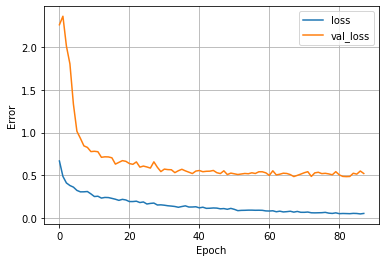

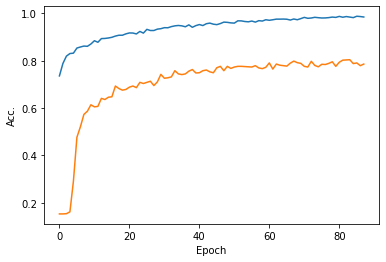

2022-03-20 17:27:16.041387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_6 (Batc  (None, 196, 96, 32)      128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 97, 47, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 97, 47, 64)       256       
 hNormalization)                                                 
                                                      

2022-03-20 17:27:19.000635: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.6812 - accuracy: 0.7267

2022-03-20 17:27:28.905862: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 2.52989, saving model to BestModel_Fold-3.h5
98/98 [==============================] - 13s 127ms/step - loss: 0.6812 - accuracy: 0.7267 - val_loss: 2.5299 - val_accuracy: 0.1699
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4900 - accuracy: 0.8006
Epoch 00002: val_loss did not improve from 2.52989
98/98 [==============================] - 12s 119ms/step - loss: 0.4900 - accuracy: 0.8005 - val_loss: 2.7573 - val_accuracy: 0.1699
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4284 - accuracy: 0.8122
Epoch 00003: val_loss improved from 2.52989 to 2.36334, saving model to BestModel_Fold-3.h5
98/98 [==============================] - 13s 128ms/step - loss: 0.4284 - accuracy: 0.8120 - val_loss: 2.3633 - val_accuracy: 0.1699
Epoch 4/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4079 - accuracy: 0.8212
Epoch 00004: val_loss improved from 2.36334 to 2.05732, saving model to BestModel

Epoch 28/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1814 - accuracy: 0.9195
Epoch 00028: val_loss did not improve from 0.64243
98/98 [==============================] - 12s 118ms/step - loss: 0.1813 - accuracy: 0.9195 - val_loss: 0.6530 - val_accuracy: 0.7095
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1856 - accuracy: 0.9230
Epoch 00029: val_loss improved from 0.64243 to 0.64214, saving model to BestModel_Fold-3.h5
98/98 [==============================] - 12s 126ms/step - loss: 0.1855 - accuracy: 0.9231 - val_loss: 0.6421 - val_accuracy: 0.7085
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1603 - accuracy: 0.9378
Epoch 00030: val_loss improved from 0.64214 to 0.63771, saving model to BestModel_Fold-3.h5
98/98 [==============================] - 12s 126ms/step - loss: 0.1605 - accuracy: 0.9376 - val_loss: 0.6377 - val_accuracy: 0.7114
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1

Epoch 56/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0987 - accuracy: 0.9575
Epoch 00056: val_loss did not improve from 0.51614
98/98 [==============================] - 12s 120ms/step - loss: 0.0987 - accuracy: 0.9575 - val_loss: 0.5493 - val_accuracy: 0.7693
Epoch 57/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0930 - accuracy: 0.9684
Epoch 00057: val_loss did not improve from 0.51614
98/98 [==============================] - 12s 121ms/step - loss: 0.0929 - accuracy: 0.9685 - val_loss: 0.5607 - val_accuracy: 0.7645
Epoch 58/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0881 - accuracy: 0.9659
Epoch 00058: val_loss did not improve from 0.51614
98/98 [==============================] - 12s 121ms/step - loss: 0.0881 - accuracy: 0.9659 - val_loss: 0.5556 - val_accuracy: 0.7654
Epoch 59/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0927 - accuracy: 0.9665
Epoch 00059: val_loss did not improve from 0.51614
98/98 [=

<Figure size 432x288 with 0 Axes>

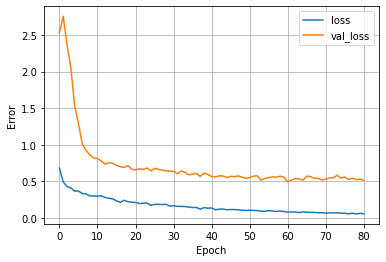

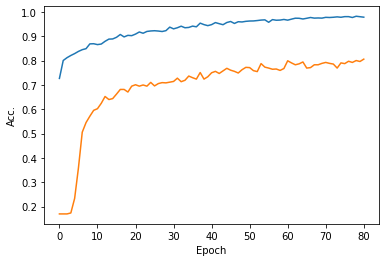

2022-03-20 17:43:27.401346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_9 (Batc  (None, 196, 96, 32)      128       
 hNormalization)                                                 
                                                                 
 conv2d_10 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 97, 47, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_10 (Bat  (None, 97, 47, 64)       256       
 chNormalization)                                                
                                                      

2022-03-20 17:43:30.160387: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.6569 - accuracy: 0.7361

2022-03-20 17:43:40.133974: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 2.25333, saving model to BestModel_Fold-4.h5
98/98 [==============================] - 13s 132ms/step - loss: 0.6569 - accuracy: 0.7361 - val_loss: 2.2533 - val_accuracy: 0.1593
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4855 - accuracy: 0.8003
Epoch 00002: val_loss did not improve from 2.25333
98/98 [==============================] - 12s 120ms/step - loss: 0.4851 - accuracy: 0.8005 - val_loss: 2.4950 - val_accuracy: 0.1593
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4083 - accuracy: 0.8225
Epoch 00003: val_loss improved from 2.25333 to 1.89372, saving model to BestModel_Fold-4.h5
98/98 [==============================] - 13s 128ms/step - loss: 0.4079 - accuracy: 0.8227 - val_loss: 1.8937 - val_accuracy: 0.1612
Epoch 4/10000
97/98 [============================>.] - ETA: 0s - loss: 0.3804 - accuracy: 0.8283
Epoch 00004: val_loss improved from 1.89372 to 1.65012, saving model to BestModel

97/98 [============================>.] - ETA: 0s - loss: 0.1626 - accuracy: 0.9304
Epoch 00028: val_loss improved from 0.54041 to 0.52543, saving model to BestModel_Fold-4.h5
98/98 [==============================] - 13s 128ms/step - loss: 0.1624 - accuracy: 0.9305 - val_loss: 0.5254 - val_accuracy: 0.7558
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9430
Epoch 00029: val_loss did not improve from 0.52543
98/98 [==============================] - 12s 120ms/step - loss: 0.1444 - accuracy: 0.9430 - val_loss: 0.5266 - val_accuracy: 0.7558
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1420 - accuracy: 0.9398
Epoch 00030: val_loss did not improve from 0.52543
98/98 [==============================] - 12s 121ms/step - loss: 0.1419 - accuracy: 0.9398 - val_loss: 0.5600 - val_accuracy: 0.7413
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1440 - accuracy: 0.9398
Epoch 00031: val_loss improved fr

97/98 [============================>.] - ETA: 0s - loss: 0.0794 - accuracy: 0.9700
Epoch 00056: val_loss did not improve from 0.41398
98/98 [==============================] - 11s 116ms/step - loss: 0.0794 - accuracy: 0.9701 - val_loss: 0.4253 - val_accuracy: 0.8205
Epoch 57/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0796 - accuracy: 0.9700
Epoch 00057: val_loss did not improve from 0.41398
98/98 [==============================] - 11s 116ms/step - loss: 0.0796 - accuracy: 0.9701 - val_loss: 0.4709 - val_accuracy: 0.7992
Epoch 58/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0756 - accuracy: 0.9726
Epoch 00058: val_loss did not improve from 0.41398
98/98 [==============================] - 11s 115ms/step - loss: 0.0756 - accuracy: 0.9726 - val_loss: 0.4367 - val_accuracy: 0.8137
Epoch 59/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9723
Epoch 00059: val_loss did not improve from 0.41398
98/98 [================

<Figure size 432x288 with 0 Axes>

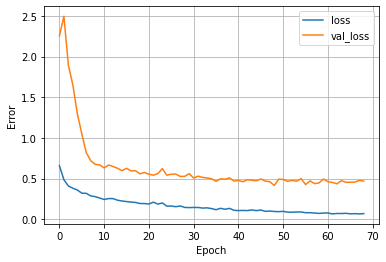

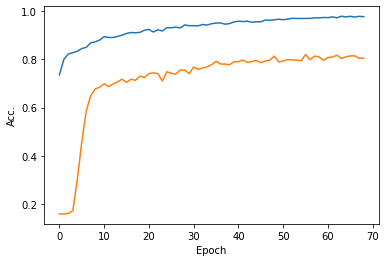

2022-03-20 17:57:21.977793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_12 (Bat  (None, 196, 96, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 97, 47, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_13 (Bat  (None, 97, 47, 64)       256       
 chNormalization)                                                
                                                      

2022-03-20 17:57:24.701519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


98/98 [==============================] - ETA: 0s - loss: 0.6746 - accuracy: 0.7355

2022-03-20 17:57:36.020188: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 2.13414, saving model to BestModel_Fold-5.h5
98/98 [==============================] - 15s 152ms/step - loss: 0.6746 - accuracy: 0.7355 - val_loss: 2.1341 - val_accuracy: 0.1680
Epoch 2/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.7993
Epoch 00002: val_loss did not improve from 2.13414
98/98 [==============================] - 12s 123ms/step - loss: 0.4755 - accuracy: 0.7992 - val_loss: 2.4656 - val_accuracy: 0.1680
Epoch 3/10000
97/98 [============================>.] - ETA: 0s - loss: 0.4288 - accuracy: 0.8057
Epoch 00003: val_loss improved from 2.13414 to 2.08893, saving model to BestModel_Fold-5.h5
98/98 [==============================] - 14s 139ms/step - loss: 0.4285 - accuracy: 0.8057 - val_loss: 2.0889 - val_accuracy: 0.1680
Epoch 4/10000
97/98 [============================>.] - ETA: 0s - loss: 0.3804 - accuracy: 0.8267
Epoch 00004: val_loss improved from 2.08893 to 1.70527, saving model to BestModel

97/98 [============================>.] - ETA: 0s - loss: 0.1702 - accuracy: 0.9230
Epoch 00028: val_loss did not improve from 0.60406
98/98 [==============================] - 12s 120ms/step - loss: 0.1701 - accuracy: 0.9231 - val_loss: 0.6058 - val_accuracy: 0.7201
Epoch 29/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1723 - accuracy: 0.9349
Epoch 00029: val_loss did not improve from 0.60406
98/98 [==============================] - 12s 119ms/step - loss: 0.1722 - accuracy: 0.9347 - val_loss: 0.6363 - val_accuracy: 0.7046
Epoch 30/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1445 - accuracy: 0.9388
Epoch 00030: val_loss improved from 0.60406 to 0.58897, saving model to BestModel_Fold-5.h5
98/98 [==============================] - 13s 128ms/step - loss: 0.1444 - accuracy: 0.9389 - val_loss: 0.5890 - val_accuracy: 0.7375
Epoch 31/10000
97/98 [============================>.] - ETA: 0s - loss: 0.1598 - accuracy: 0.9352
Epoch 00031: val_loss did not imp

Epoch 56/10000
98/98 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9678
Epoch 00056: val_loss improved from 0.50155 to 0.48357, saving model to BestModel_Fold-5.h5
98/98 [==============================] - 13s 131ms/step - loss: 0.0873 - accuracy: 0.9678 - val_loss: 0.4836 - val_accuracy: 0.7963
Epoch 57/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0929 - accuracy: 0.9713
Epoch 00057: val_loss did not improve from 0.48357
98/98 [==============================] - 12s 122ms/step - loss: 0.0928 - accuracy: 0.9714 - val_loss: 0.5377 - val_accuracy: 0.7712
Epoch 58/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0835 - accuracy: 0.9675
Epoch 00058: val_loss did not improve from 0.48357
98/98 [==============================] - 12s 121ms/step - loss: 0.0834 - accuracy: 0.9675 - val_loss: 0.5073 - val_accuracy: 0.7934
Epoch 59/10000
97/98 [============================>.] - ETA: 0s - loss: 0.0801 - accuracy: 0.9710
Epoch 00059: val_l

<Figure size 432x288 with 0 Axes>

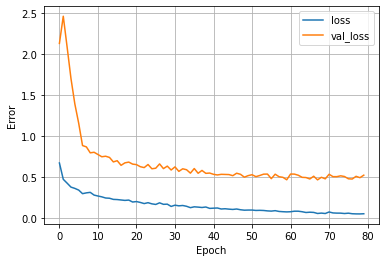

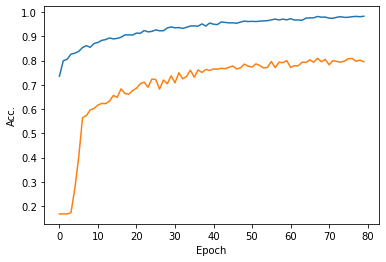

2022-03-20 18:13:40.292535: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [14]:
train()

2022-02-28 17:37:25.266448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Percentage misclassified =  [16.35450859 16.35450859 16.35450859 ... 83.66480015 16.35450859
 16.35450859]
Percentage misclassified =  31.722306292800933


/Users/tomas/miniforge3/lib/python3.9/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 196, 96, 32)       832       
                                                                 
 batch_normalization_19 (Bat  (None, 196, 96, 32)      128       
 chNormalization)                                                
                                                                 
 conv2d_39 (Conv2D)          (None, 194, 94, 64)       18496     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 97, 47, 64)       0         
 g2D)                                                            
                                                                 
 flatten_20 (Flatten)        (None, 291776)            0         
                                                                 
 dense_38 (Dense)            (None, 256)             

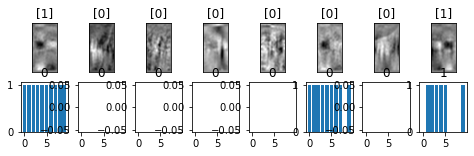

In [18]:
test('cnn_for_5H_trial1.h5')